In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import seaborn as sns

import requests
import io
import pandas as pd

import zipfile
import re
import os

import unicodedata
import string

### Downloading data and converting it to a dataframe

In [2]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readfile(filename, z):
    content = z.read(filename)
    language = os.path.splitext(os.path.basename(filename))[0]
    names = content.decode("utf-8").split("\n")
    return language, [unicodeToAscii(name.strip().lower()) for name in names if len(name.strip()) > 0]

def buildnames(url):
    response = requests.get(url)
    b = io.BytesIO(response.content)
    z = zipfile.ZipFile(b)
    
    pattern = re.compile(r"^data/names/(\w+)\.txt")
    filenames = [f.filename for f in z.infolist() if re.match(pattern, f.filename)]
    
    all_names = []
    
    for filename in filenames:
        language, names = readfile(filename, z)
        all_names += list(zip([language]*len(names), names))
        
    return pd.DataFrame(all_names, columns=["language", "person_name"]).drop_duplicates()

In [3]:
all_letters = string.ascii_lowercase + " .,;'"
n_letters = len(all_letters)
url = "https://download.pytorch.org/tutorial/data.zip"

names = buildnames(url)
languages = names.language.unique()
nlanguages = len(languages)
max_len = names.person_name.apply(len).max() 

language_to_idx = dict([(language, i) for (i, language) in enumerate(languages)])
idx_to_language = dict([(i, language) for (language, i) in language_to_idx.items()])

train, valid = train_test_split(names, test_size=0.2, stratify=names.language)

### Encoding names into tensors
It is important that the all names are encoded to the same length. Also, it is important that the padding is done in the front

In [4]:
def letter_to_index(letter):
    return all_letters.find(letter) + 1 # zero is reserved for padding
    
def name_to_tensor(name, max_len):
    name = name.lower()
    name_tensor = torch.zeros(max_len, dtype=torch.long)
    for i, letter in enumerate(name):
        name_tensor[-(len(name) - i)] = letter_to_index(letter)
            
    return name_tensor

### Torch dataset

In [5]:
class NamesDataset(Dataset):
    def __init__(self, dataframe, max_len):
        self.dataframe = dataframe
        self.max_len = max_len
        
    def __len__(self):
        return len(self.dataframe.index)
    
    def __getitem__(self, item):
        row = self.dataframe.loc[item]
        
        name = row.person_name
        language = row.language
        
        language_idx = language_to_idx[language]
        name_tensor = name_to_tensor(name, self.max_len)
        
        return {
            "language_idx": torch.tensor(language_idx, dtype=torch.long),
            "name_tensor": name_tensor
        }

### The Embedding layer
Embedding layer is initialized with a shape `(num_embeddings, embedding_dim)`. The first dimension corresponds to the max index. For example, if we want to train a character level network with 27 characters (space + 26 alphabets), then we will used `num_embeddings=27`. The layer will be initialized with random values that will be learned during training. 

In [6]:
class CharacterNet(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size):
        super(CharacterNet, self).__init__()
        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.embedding(x)
        out, hidden = self.rnn(x)
        x = self.linear(out[:,-1,:])
        return x

### Training model

In [7]:
def train_epoch(plot_losses=True):
    train_losses, valid_losses = [], []
    train_loss, valid_loss = 0, 0
    
    model.train()
    for train_data in train_dataloader:
        name_tensor = train_data["name_tensor"]
        language_idx = train_data["language_idx"]
        
        with torch.set_grad_enabled(True):
            output = model(name_tensor)
            loss = loss_function(output, language_idx)
            
            loss.backward()
            
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.item()
            train_losses += [loss.item() / len(language_idx)]
        
    model.eval()
    for valid_data in valid_dataloader:
        name_tensor = valid_data["name_tensor"]
        language_idx = valid_data["language_idx"]
        
        with torch.set_grad_enabled(False):
            output = model(name_tensor)
            loss = loss_function(output, language_idx)
    
            valid_loss += loss.item()
            valid_losses += [loss.item() / len(language_idx)]
    
    if plot_losses:
        # plotting losess
        ax = sns.lineplot(list(range(len(train_losses))), train_losses, label="train")
    #     ax = sns.lineplot(list(range(len(valid_losses))), valid_losses, label="valid")
    #     ax.set_title(f"Train and valid losses");
    
    train_loss /= len(train_dataloader.dataset)
    valid_loss /= len(valid_dataloader.dataset)
    
    print(f"Epoch train loss: {train_loss:.4f}, Epoch valid loss: {valid_loss:.4f}")
        
    return train_loss, valid_loss

In [8]:
batch_size = 32

train_dataset = NamesDataset(train.reset_index(), max_len)
valid_dataset = NamesDataset(valid.reset_index(), max_len)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

### Train loss per mini-batch

Epoch train loss: 1.4599, Epoch valid loss: 1.1931


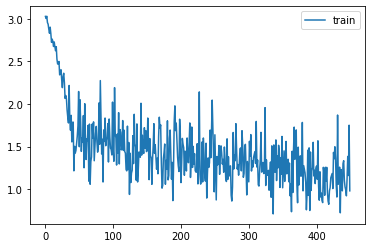

In [9]:
model = CharacterNet(n_letters+1, 10, 40, nlanguages)
loss_function = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss, valid_loss = train_epoch()

### Training model for 20 epochs

In [10]:
model = CharacterNet(n_letters+1, 10, 40, nlanguages)
loss_function = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, valid_losses = [], []

for _ in range(20):
    train_loss, valid_loss = train_epoch(plot_losses=False)
    train_losses += [train_loss]
    valid_losses += [valid_loss]

Epoch train loss: 1.4393, Epoch valid loss: 1.1749
Epoch train loss: 1.0974, Epoch valid loss: 1.0411
Epoch train loss: 1.0040, Epoch valid loss: 0.9645
Epoch train loss: 0.9489, Epoch valid loss: 0.9282
Epoch train loss: 0.9099, Epoch valid loss: 0.8914
Epoch train loss: 0.8773, Epoch valid loss: 0.8791
Epoch train loss: 0.8535, Epoch valid loss: 0.8553
Epoch train loss: 0.8316, Epoch valid loss: 0.8469
Epoch train loss: 0.8126, Epoch valid loss: 0.8368
Epoch train loss: 0.7941, Epoch valid loss: 0.8200
Epoch train loss: 0.7790, Epoch valid loss: 0.8033
Epoch train loss: 0.7654, Epoch valid loss: 0.7970
Epoch train loss: 0.7500, Epoch valid loss: 0.7877
Epoch train loss: 0.7414, Epoch valid loss: 0.7871
Epoch train loss: 0.7288, Epoch valid loss: 0.7782
Epoch train loss: 0.7194, Epoch valid loss: 0.7758
Epoch train loss: 0.7117, Epoch valid loss: 0.7686
Epoch train loss: 0.7022, Epoch valid loss: 0.7684
Epoch train loss: 0.6956, Epoch valid loss: 0.7645
Epoch train loss: 0.6873, Epoch

Text(0.5, 1.0, 'Train and validation losses by epoch')

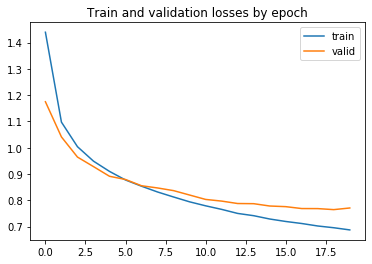

In [11]:
x = list(range(len(train_losses)))

ax = sns.lineplot(x, train_losses, label="train")
sns.lineplot(x, valid_losses, label="valid", ax=ax)
ax.set_title("Train and validation losses by epoch")

### Model inference

In [12]:
def eval_model(dataloader):
    n_accurate = 0
    model.eval()
    for valid_data in dataloader:
        name_tensor = valid_data["name_tensor"]
        language_idx = valid_data["language_idx"]

        with torch.set_grad_enabled(False):
            logits = model(name_tensor)
            preds = torch.argmax(logits, axis=1)
            n_accurate += torch.sum(preds==language_idx).item()

    accuracy = n_accurate / len(dataloader.dataset)
    return accuracy

print(f"Training accuracy   = {eval_model(train_dataloader):.4f}")
print(f"Validation accuracy = {eval_model(valid_dataloader):.4f}")

Training accuracy   = 0.8001
Validation accuracy = 0.7749


### Prediction for single name

In [13]:
def predict_language(name):
    name_tensor = name_to_tensor(name, max_len)
    logits = model(name_tensor.unsqueeze(0))
    pred = torch.argmax(logits, axis=1)
    language = idx_to_language[pred.item()]
    return language

In [14]:
for i, row in names.sample(n=10).iterrows():
    p_language = predict_language(row.person_name)
    
    if p_language == row.language:
        print(f"Name: {row.person_name:12} Prediction: {p_language:10} <- Correct")
    else:
        print(f"Name: {row.person_name:12} Prediction: {p_language:10} <- Incorrect (Correct = {row.language})")

Name: dobryakov    Prediction: Russian    <- Correct
Name: noskov       Prediction: Russian    <- Correct
Name: martinkus    Prediction: Russian    <- Correct
Name: atalian      Prediction: Russian    <- Correct
Name: herbert      Prediction: English    <- Incorrect (Correct = German)
Name: cheng        Prediction: Chinese    <- Correct
Name: glazunov     Prediction: Russian    <- Correct
Name: krivolavy    Prediction: Russian    <- Incorrect (Correct = Czech)
Name: maria        Prediction: Japanese   <- Incorrect (Correct = Spanish)
Name: endolov      Prediction: Russian    <- Correct
